In [1]:
from typing import List, Callable


class Param:
    def __init__(self, name: str, distribution: Callable):
        self.name = name
        self.distribution = distribution

    def create_value(self):
        return self.distribution()


class StageType:
    def __init__(self, name, params):
        self.name = name
        self.params = params


class Stage:
    def __init__(self, stage_type: StageType, values: List):
        self.stage_type = stage_type
        self.values = values

    def __str__(self):
        return f"Stage(name={self.stage_type.name}, values={self.values})"


def create_stage(stage_type: StageType) -> Stage:
    return Stage(stage_type, [param.create_value() for param in stage_type.params])


class Pipline:
    def __init__(self, stages: List[Stage]):
        self.stages = stages

    def __str__(self):
        return f'Pipeline(stages={" ".join(map(str, self.stages))})'

In [38]:
class GA:
    def __init__(self,
                 stage_types: List[StageType],
                 population_size: int,
                 pipeline_size_distribution: Callable[[], int],
                 fitness: Callable[[Pipline], float],
                 generations: int):
        self.stage_types = stage_types
        self.population_size = population_size
        self.pipeline_size_distribution = pipeline_size_distribution
        self.fitness = fitness
        self.generations = generations

    def create_initial_population(self) -> List[Pipline]:
        sizes = [self.pipeline_size_distribution() for _ in range(self.population_size)]
        return [Pipline(list(map(create_stage, np.random.choice(self.stage_types, size)))) for size in sizes]

    def sort(self, population: List[Pipline]):
        population.sort(key=self.fitness)


def genetic_algorithm(self, population: List[Pipline], mutation_rate: float) -> Stage:
    
    for generation in range(self.generations):
        # Select parents for crossover
        parents = np.random.choice(population, 2)

        # Perform crossover
        child = crossover(parents[0], parents[1])

        # Perform mutation on the child
        child = mutate(child, mutation_rate)

        # Replace a random individual in the population with the child
        index_to_replace = random.randint(0, len(population) - 1)
        population[index_to_replace] = child

    # Return the best individual in the final population (you might need to define a fitness function)
    best_individual = max(population, key=lambda stage: fitness_function(stage))
    return best_individual

In [39]:
def crossover(parent1: Stage, parent2: Stage) -> Stage:
    crossover_point = np.random.randint(1, len(parent1.values) - 1)

    child_values = parent1.values[:crossover_point] + parent2.values[crossover_point:]

    child_stage = Stage(parent1.stage_type, child_values)

    return child_stage


def mutate(stage: Stage, mutation_rate: float) -> Stage:
    mutated_values = [
        param.create_value() if np.random.random() < mutation_rate else value
        for param, value in zip(stage.stage_type.params, stage.values)
    ]

    # Create a new stage using the mutated values
    mutated_stage = Stage(stage.stage_type, mutated_values)

    return mutated_stage




In [40]:
import numpy as np

In [41]:
size_param = Param("size", lambda: np.random.randint(1, 5))


class ColorStage(StageType):
    def __init__(self, color: str):
        super().__init__(color, [size_param])


red_stage = ColorStage("red")
green_stage = ColorStage("green")
blue_stage = ColorStage("blue")


def evaluate(pipeline: Pipline) -> int:
    res = 0
    i = 0
    n = len(pipeline.stages)
    while i < n:
        if pipeline.stages[i].stage_type.name == "red" and i < n - 2 and \
                pipeline.stages[i + 1].stage_type.name == "green" and \
                pipeline.stages[i + 2].stage_type.name == "blue":
            res += sum([sum(pipeline.stages[j].values) for j in range(i, i + 3)]) ** 2
            i += 3
        else:
            res -= sum(pipeline.stages[i].values)
            i += 1
    return res



In [50]:
import matplotlib.pyplot as plt


def visualize(pipelines: List[Pipline]):
    fig, ax = plt.subplots(figsize=(20, 20))

    max_stages = 0
    for n, pipeline in enumerate(pipelines):
        max_stages = max(max_stages, len(pipeline.stages))
        for i, stage in enumerate(pipeline.stages):
            name = stage.stage_type.name
            color = "r" if name == "red" else "g" if name == "green" else "b"
            ax.scatter(i, n, color=color, edgecolors='black', s=1000)
            ax.text(i, n, str(stage.values[0]), ha='center', va='center', color='w', fontweight='bold')
        ax.text(-1, n, str(evaluate(pipeline)), ha='center', va='center', fontweight='bold')

    ax.set_xlim(-2, max_stages)
    ax.set_ylim(-1, len(pipelines) + 1)
    ax.axis('off')

    plt.show()



In [51]:
ga = GA([red_stage, green_stage, blue_stage], 20, lambda: np.random.randint(1, 10), evaluate)
population = ga.create_initial_population()


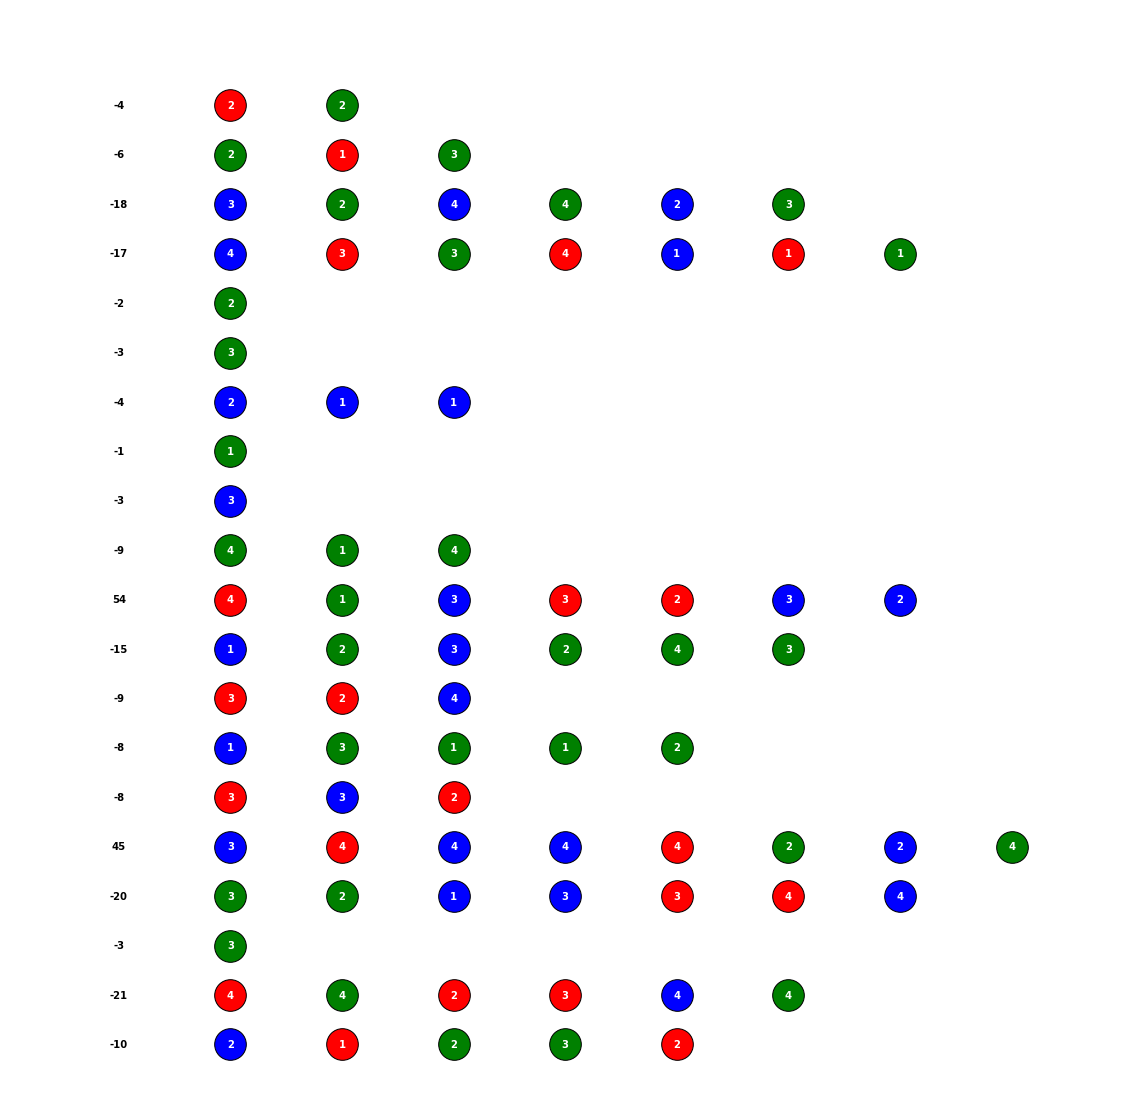

In [52]:
visualize(population)

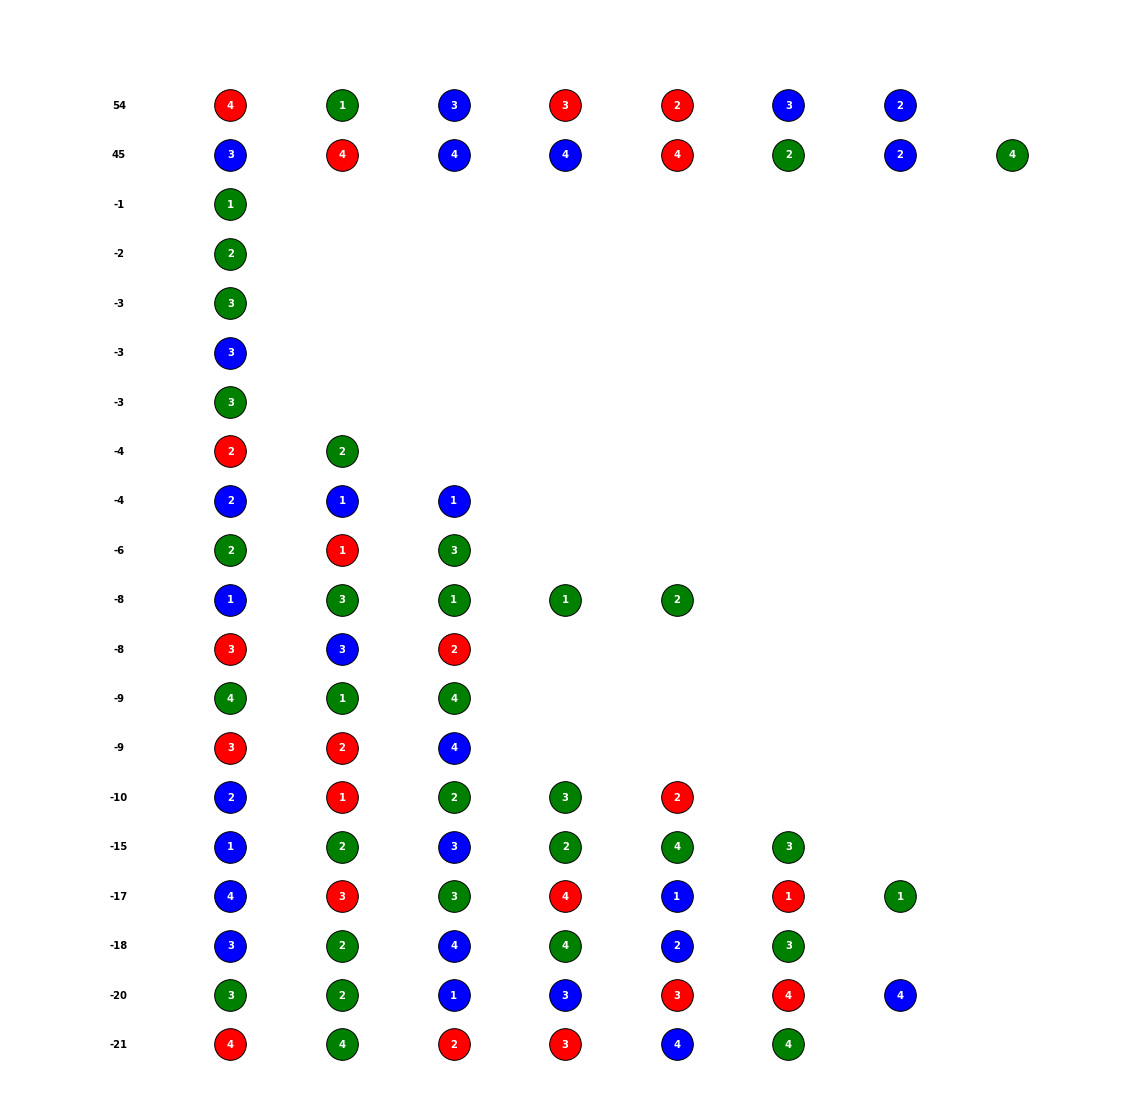

In [53]:
ga.sort(population)
visualize(population)